In [64]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns

In [65]:
magic_num = 0

if magic_num == 0:
    source_path = r"C:/Cody/Research/clean_data/prepare.csv"
    output_graph_file = r"C:/Cody/Research/Chapter4資料探勘與趨勢分析/TicketSituationDifference_chart/"
elif magic_num == 1:
    source_path = r"D:/Research/clean_data/prepare.csv"
    output_graph_file = r"D:/Research/Chapter4資料探勘與趨勢分析/TicketSituationDifference_chart/"
else:
    print("wrong magic num.")
    exit(1)

data = pd.read_csv(source_path)

In [66]:
data["全時間格式進入時間"] = pd.to_datetime(data["全時間格式進入時間"], errors="coerce")
data["全時間格式出場時間"] = pd.to_datetime(data["全時間格式出場時間"], errors="coerce")
# 移除時間缺失與異常值
data = data.dropna(subset=["全時間格式進入時間", "全時間格式出場時間"])
data = data[data["全時間格式出場時間"] > data["全時間格式進入時間"]]

# 不須分析機車
data = data[data["票種"] != "學生機車證"]

In [67]:
tag = data["票種"].unique()
print("票種清單:", tag)
ticket_directory = {}

for each_cat in tag:
    temp_df = data[data["票種"] == each_cat].copy()  # 創建獨立副本
    if temp_df.empty:
        print(f"警告: {each_cat} 無數據，已跳過")
        continue
    temp_df.loc[:, "停留時數_分鐘"] = (temp_df["全時間格式出場時間"] - temp_df["全時間格式進入時間"]).dt.total_seconds() / 60  # 使用 .loc 賦值
    ticket_directory[each_cat] = temp_df
    print(f"{each_cat}: {len(temp_df)} 筆記錄")

票種清單: ['臨停車' '學生計次汽車' '教職員汽車' '學生長時汽車' '臨時貴賓' '廠商汽車證' '教職員計次' '身障優惠'
 '退休及校友汽車識別證' '在職專班汽車' '退休及校友臨停' '互惠車輛' '長時廠商汽車' '特殊入校車輛']
臨停車: 502474 筆記錄
學生計次汽車: 75434 筆記錄
教職員汽車: 288116 筆記錄
學生長時汽車: 52489 筆記錄
臨時貴賓: 31515 筆記錄
廠商汽車證: 75218 筆記錄
教職員計次: 5710 筆記錄
身障優惠: 2285 筆記錄
退休及校友汽車識別證: 27703 筆記錄
在職專班汽車: 18271 筆記錄
退休及校友臨停: 8615 筆記錄
互惠車輛: 4329 筆記錄
長時廠商汽車: 2529 筆記錄
特殊入校車輛: 42 筆記錄


In [68]:
for cat in ticket_directory:
    print(f"{cat}  停留時數_分鐘範圍: {ticket_directory[cat]['停留時數_分鐘'].min():.2f} - {ticket_directory[cat]['停留時數_分鐘'].max():.2f}")

臨停車  停留時數_分鐘範圍: 0.02 - 7195.62
學生計次汽車  停留時數_分鐘範圍: 0.12 - 7191.37
教職員汽車  停留時數_分鐘範圍: 0.02 - 7196.33
學生長時汽車  停留時數_分鐘範圍: 0.15 - 7199.58
臨時貴賓  停留時數_分鐘範圍: 0.10 - 7176.53
廠商汽車證  停留時數_分鐘範圍: 0.05 - 7197.28
教職員計次  停留時數_分鐘範圍: 0.35 - 5897.73
身障優惠  停留時數_分鐘範圍: 1.13 - 2390.27
退休及校友汽車識別證  停留時數_分鐘範圍: 0.23 - 5471.63
在職專班汽車  停留時數_分鐘範圍: 0.10 - 7118.40
退休及校友臨停  停留時數_分鐘範圍: 1.63 - 1862.87
互惠車輛  停留時數_分鐘範圍: 0.27 - 6615.18
長時廠商汽車  停留時數_分鐘範圍: 0.30 - 7041.12
特殊入校車輛  停留時數_分鐘範圍: 0.50 - 7166.38


# 開始對各式票種分析停留時間分布

Bins 數量: 64


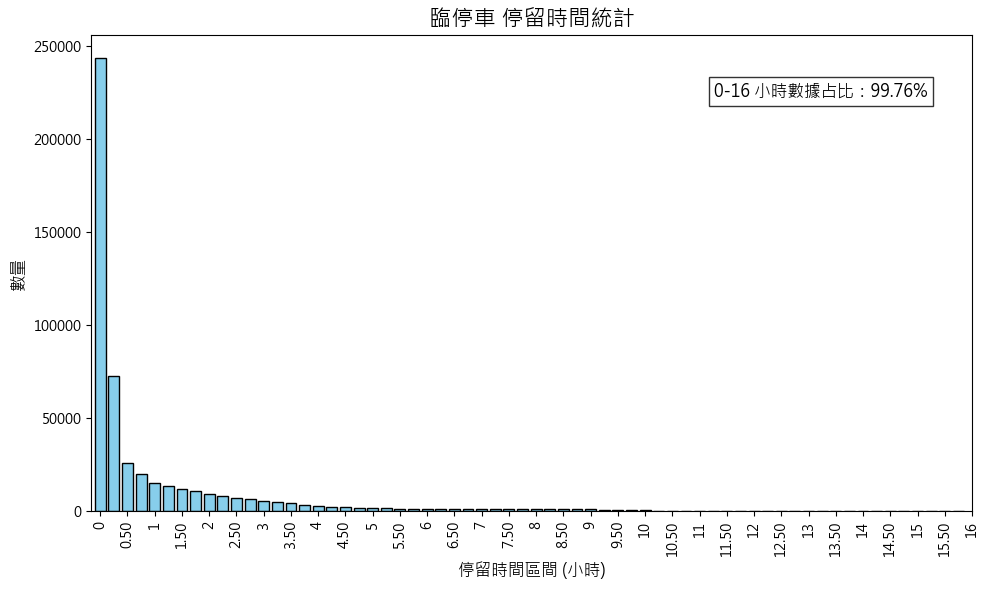

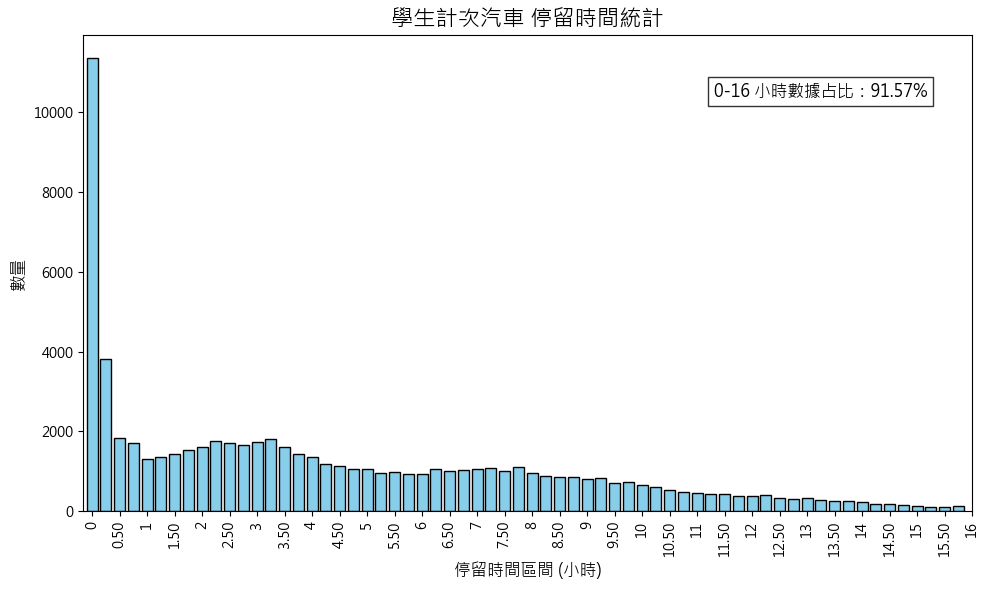

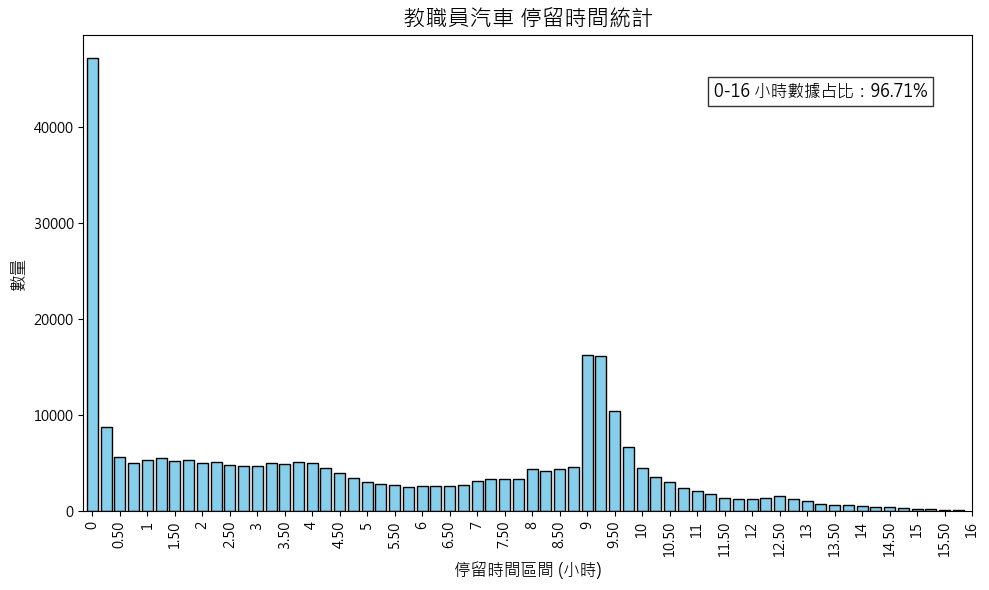

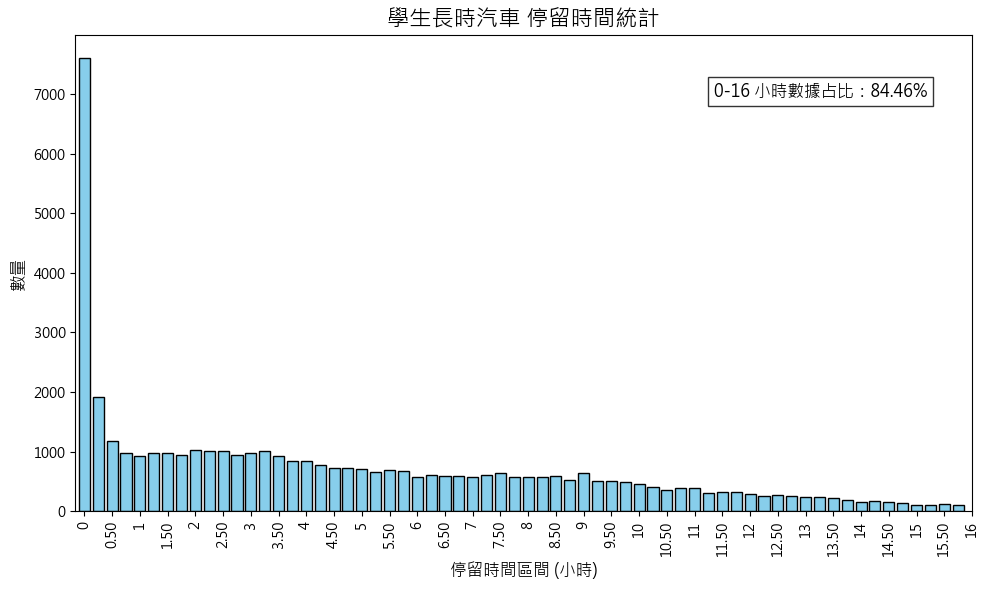

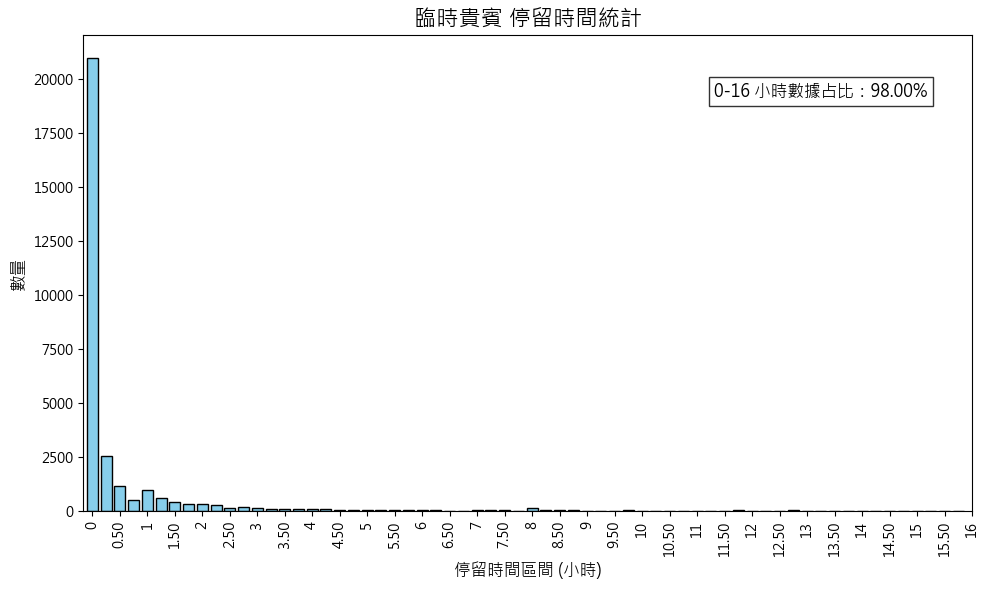

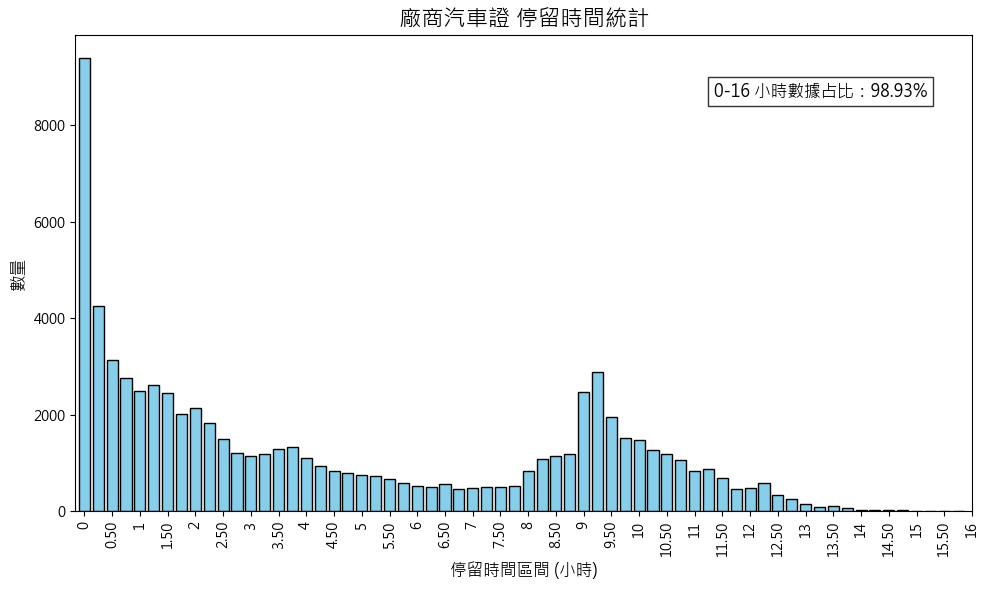

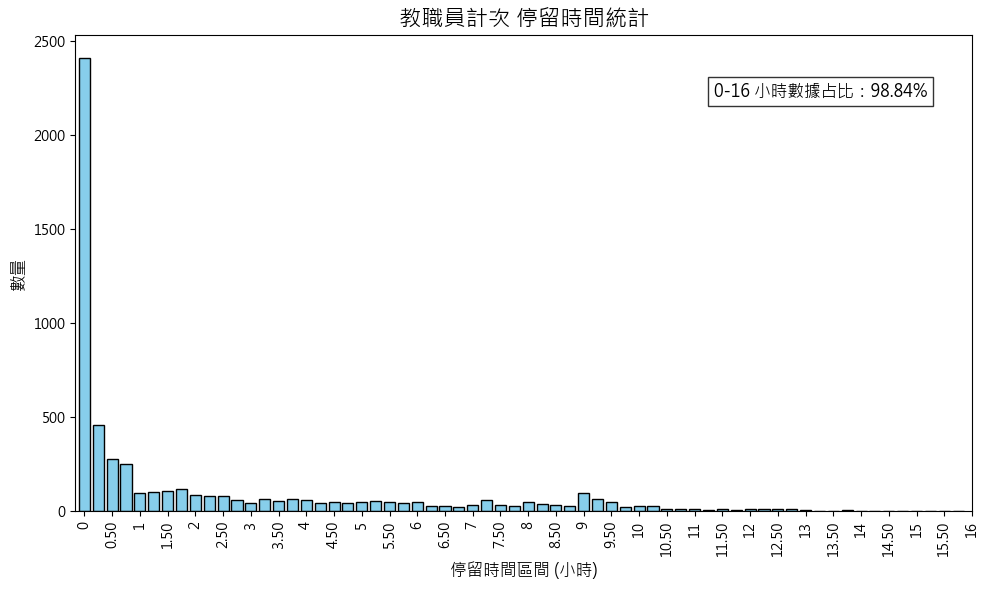

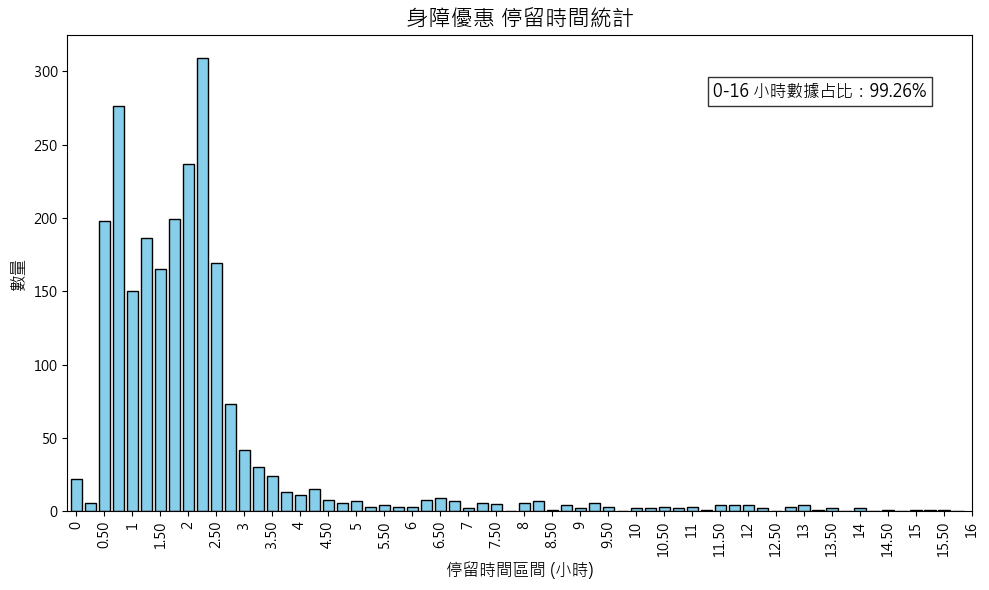

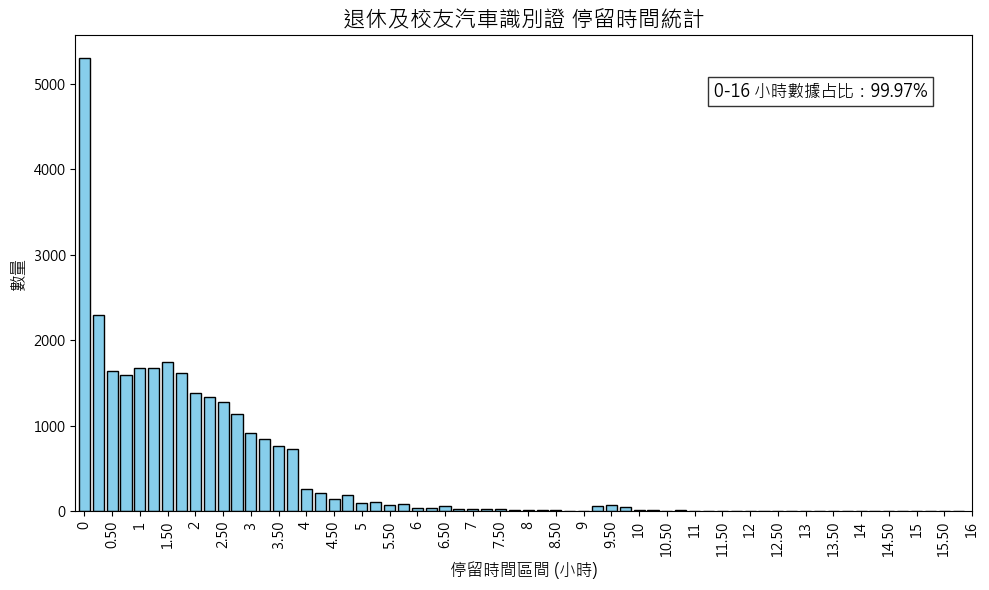

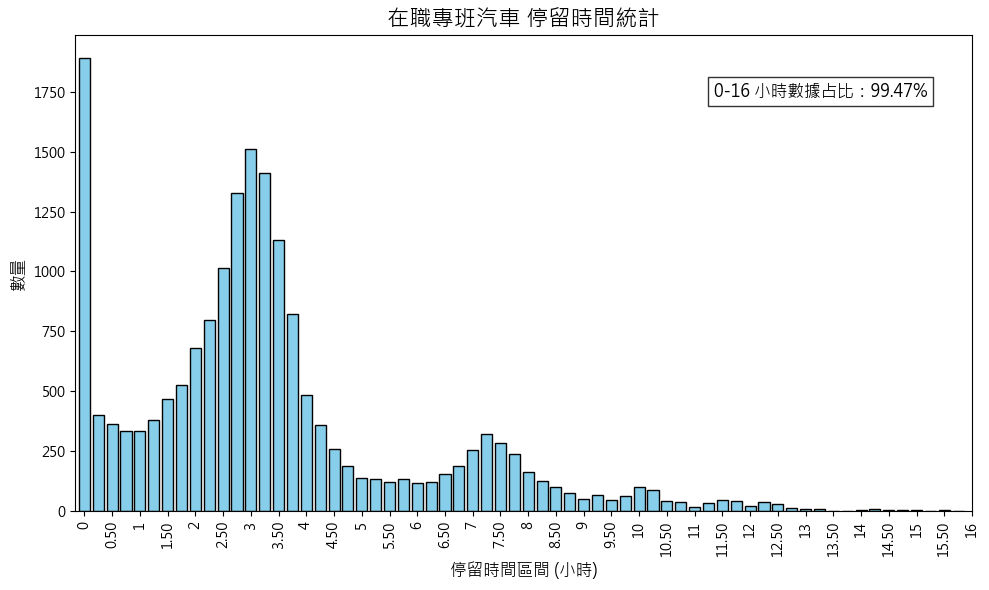

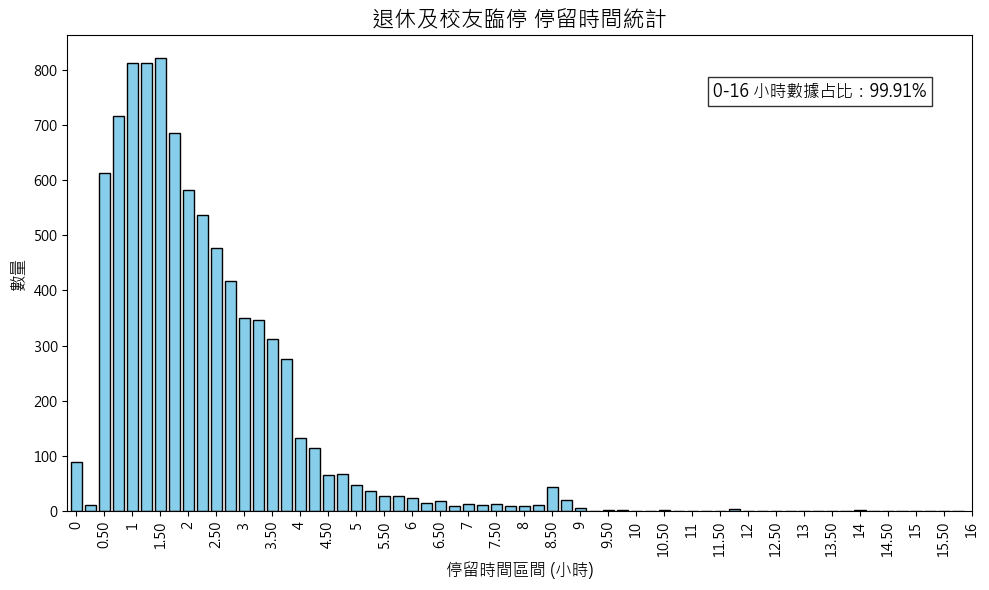

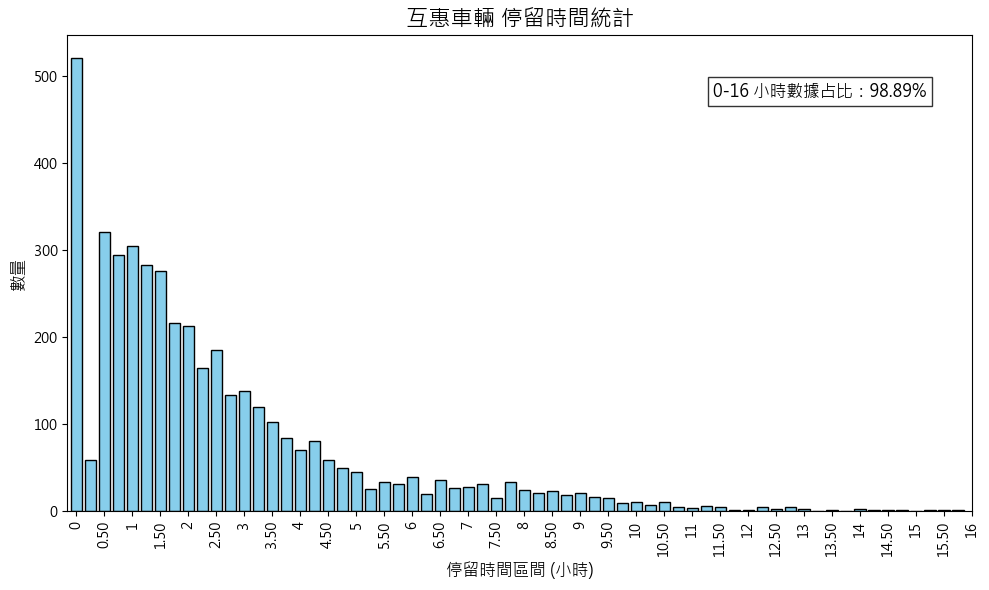

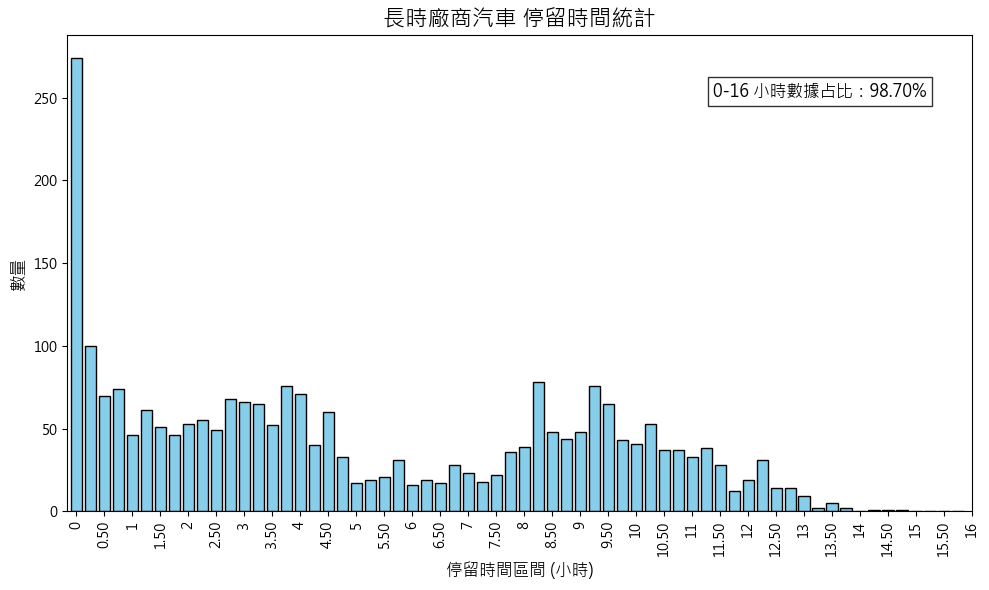

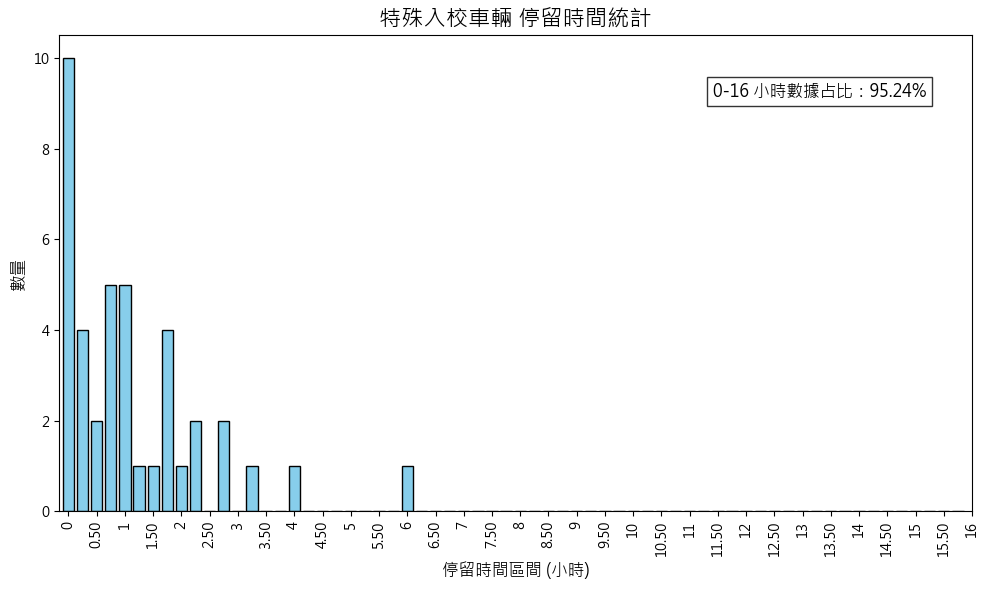

In [69]:
# 設定中文字型
plt.rcParams['font.family'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False  # 確保負號顯示正確

# 定義直方圖的 bin（15 分鐘 = 0.25 小時）
bin_width = 0.25
short_start, short_end = 0.5, 1
regular_start, regular_end = 6, 8
# 換算為 index
short_start_idx = int(short_start / bin_width)
short_end_idx = int(short_end / bin_width)
regular_start_idx = int(regular_start / bin_width)
regular_end_idx = int(regular_end / bin_width)

max_hours = 16  # 統計到 16 小時
bins = np.arange(0, max_hours + bin_width, bin_width)
print("Bins 數量:", len(bins) - 1)



for cat in ticket_directory:
    # 計算該票種總資料數
    total_count = len(ticket_directory[cat])
    # 計算落在 16 小時內的資料數（即 bins 範圍內）
    stay_hours = ticket_directory[cat]['停留時數_分鐘'] / 60
    in_range_mask = (stay_hours >= 0) & (stay_hours < max_hours)
    in_range_count = in_range_mask.sum()
    

    # 計算百分比
    in_range_percent = (in_range_count / total_count )* 100 if total_count > 0 else 0

    # 計算每筆資料對應的區間
    ticket_directory[cat]['停留時數_分鐘'] = ticket_directory[cat]['停留時數_分鐘'].astype(float)
    hist, edges = pd.cut(stay_hours, bins=bins, right=False, include_lowest=True, retbins=True)


    # 計算每個區間的數量
    counts = hist.value_counts(sort=False)

    # 畫圖
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', width=0.8, color='skyblue', edgecolor='black')
    plt.title(f'{cat} 停留時間統計', fontsize=16)
    plt.xlabel('停留時間區間 (小時)', fontsize=12)
    plt.ylabel('數量', fontsize=12)

    # 設置 x 軸刻度（每 15 分鐘刻度，每 0.5 小時標籤）
    tick_positions = np.arange(0, max_hours + bin_width, bin_width)             # 每 15 分鐘
    label_positions = np.arange(0, max_hours + 0.5, 0.5)                        # 每 0.5 小時標籤
    label_indices = (label_positions / bin_width).astype(int)                   # 對應 bin 索引
    plt.xticks(label_indices, [f"{x:.2f}" if x % 1 else f"{x:.0f}" for x in label_positions])

    plt.text(0.95, 0.90, f"0-16 小時數據占比：{in_range_percent:.2f}%", 
                 transform=plt.gca().transAxes, fontsize=12, 
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.tight_layout()
    plt.show()
